In [1]:
%load_ext autoreload
%autoreload 2

# Analyzing the trained model

In [2]:
# import os; os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]=".99"

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

from typing import Any, Callable, Sequence, Union
import numpy as np

import tensorflow as tf
tf.config.set_visible_devices([], device_type='GPU')

import jax
from jax import lax, random, numpy as jnp
from flax.core import freeze, unfreeze, FrozenDict
from flax import linen as nn
from flax import struct
from flax.training import train_state
from flax.training import orbax_utils

import optax
import orbax.checkpoint

from clu import metrics
from ml_collections import ConfigDict

from einops import reduce, rearrange
import wandb
from iqadatasets.datasets import *
from fxlayers.layers import *
from fxlayers.layers import GaussianLayerGamma, GaborLayerLogSigma_, FreqGaussianGamma, OrientGaussianGamma
from fxlayers.initializers import *
from JaxPlayground.utils.constraints import *
from JaxPlayground.utils.wandb import *

2023-12-15 14:34:50.029434: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# jax.config.update("jax_debug_nans", False)

## Generate the stimuli

We will be generating an image with a given background frequency and a given stimuli frequency.

In [ ]:
from perceptualtests.color_matrices import *
from perceptualtests.utils import *

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# f_tests = np.array([2, 4, 8, 16, 32])
f_tests = np.array([1, 2, 4, 8, 16, 30])
num_rows, num_cols = 256, 256
num_frames = 1
fs = 64 # 6H -> 40 
L0 = 40 #cd/m2
sigma = num_rows/(fs*4)
c_noises = [0.042]#0.1*np.linspace(0,1,8)

In [ ]:
[x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
x0 = np.max(x)/2
y0 = np.max(y)/2

In [ ]:
## Gaussiana para la ventana
g = np.exp(-((x-x0)**2)/sigma**2-((y-y0)**2)/sigma**2)

In [ ]:
def gaussian_window(x, y, sigma):
    """
    Defines a Gaussian window over the domain (x, y).
    """
    x0, y0 = np.max(x)/2, np.max(y)/2
    return np.exp(-((x-x0)**2)/sigma**2-((y-y0)**2)/sigma**2)

In [ ]:
def create_noises(f_tests = np.array([1, 2, 4, 8, 16, 30]),
                  num_rows = 256, 
                  num_cols = 256,
                  num_frames = 1,
                  fs = 64,
                  L0 = 40,
                  c_noises = [0.1],
                  color_noise = np.array([1, 0, 0])[None,:],
                  delta_angle = 180,
                  angle = 0,
                  gs = None,
                  **kwargs):

    [x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
    x0 = np.max(x)/2
    y0 = np.max(y)/2

    if gs is None:
        gs = np.ones_like(x)
    elif callable(gs):
        gs = gs(x, y, **kwargs)

    delta_f = f_tests/4

    noises_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    noises = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    for l, f_test in enumerate(f_tests):
        fm = f_test - delta_f[l]
        fM = f_test + delta_f[l]
        nx, nf, F_noise = noise(fx, fy, fm, fM, angle, delta_angle)
        nx = nx*gs
        
        for j, c_noise in enumerate(c_noises):
            nx2 = control_lum_contrast(nx + L0, L0, c_noise) - L0
            nx2 = nx2[:,:,None]@color_noise
            nx2[:,:,0] = nx2[:,:,0] + L0
            noises_atd[l,j,:,:,:] = nx2
            nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
            nx2 = np.sqrt(nx2)
            noises[l,j,:,:,:] = nx2
    return noises_atd.squeeze(), noises.squeeze()

In [ ]:
def create_background(f_tests = np.array([1, 2, 4, 8, 16, 30]),
                      num_rows = 256, 
                      num_cols = 256,
                      num_frames = 1,
                      fs = 64,
                      L0 = 40,
                      c_noises = [0.1],
                      color_noise = np.array([1, 0, 0])[None,:],
                      delta_angle = 180,
                      angle = 0,
                      gs = None,
                      **kwargs):

    [x,y,t,fx,fy,ft] = spatio_temp_freq_domain(num_rows, num_cols, num_frames, fs, fs, num_frames)
    x0 = np.max(x)/2
    y0 = np.max(y)/2

    if gs is None:
        gs = np.ones_like(x)
    elif callable(gs):
        gs = gs(x, y, **kwargs)

    delta_f = f_tests/4

    noises_atd = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    noises = np.empty(shape=(len(f_tests),len(c_noises),num_rows,num_cols,3))
    for l, f_test in enumerate(f_tests):
        fm = f_test - delta_f[l]
        fM = f_test + delta_f[l]
        nx, nf, F_noise = noise(fx, fy, fm, fM, angle, delta_angle)
        nx = nx*gs
        
        for j, c_noise in enumerate(c_noises):
            nx2 = control_lum_contrast(nx + L0, L0, c_noise) - L0
            nx2 = nx2[:,:,None]@color_noise
            nx2[:,:,0] = nx2[:,:,0] + L0
            noises_atd[l,j,:,:,:] = nx2
            nx2 = nx2@Matd2xyz.T@Mxyz2ng.T
            nx2 = np.sqrt(nx2)
            noises[l,j,:,:,:] = nx2
    return noises_atd.squeeze(), noises.squeeze()

## Generate noises (achromatic and chromatic)

In [ ]:
f_tests

array([ 1,  2,  4,  8, 16, 30])

In [ ]:
noises_a_atd, noises_a = create_noises(f_tests=f_tests,
                                   num_rows = 256, 
                                   num_cols = 256,
                                   fs = 64,
                                   L0 = L0,
                                   c_noises = c_noises,
                                   color_noise = np.array([1, 0, 0])[None,:],
                                   gs = g,
                                   delta_angle=7)
noises_a.shape, noises_a_atd.shape

((6, 256, 256, 3), (6, 256, 256, 3))

In [ ]:
bg = np.array([L0, 0, 0])[None,None,None,:]
bg.shape

(1, 1, 1, 3)

In [ ]:
((noises_a_atd-bg)**2).sum(axis=(1,2))**(1/2)

array([[304.11248445,   0.        ,   0.        ],
       [304.11248445,   0.        ,   0.        ],
       [304.11248445,   0.        ,   0.        ],
       [304.11248445,   0.        ,   0.        ],
       [304.11248445,   0.        ,   0.        ],
       [304.11248445,   0.        ,   0.        ]])

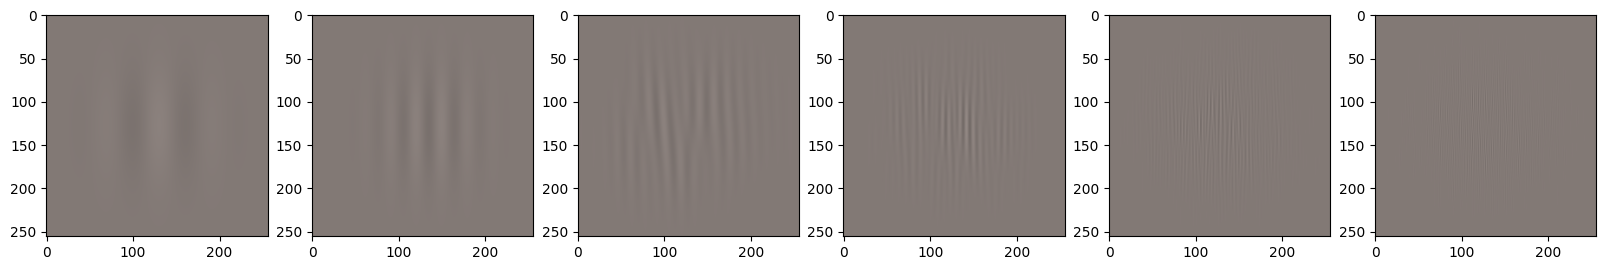

In [ ]:
fig, ax = plt.subplots(1,len(noises_a), figsize=(20, 9))

for i, noise_ in enumerate(noises_a):
    ax[i].imshow(noise_)
plt.show()

In [ ]:
noises_t_atd, noises_t = create_noises(f_tests=f_tests,
                                   num_rows = 256, 
                                   num_cols = 256,
                                   fs = 64,
                                   L0 = L0,
                                   c_noises = c_noises,
                                   color_noise = np.array([0, 1, 0])[None,:],
                                   gs = g,
                                   delta_angle=7)
noises_t.shape, noises_t_atd.shape

((6, 256, 256, 3), (6, 256, 256, 3))

In [ ]:
((noises_t_atd-bg)**2).sum(axis=(1,2))**(1/2)

array([[  0.        , 304.11248445,   0.        ],
       [  0.        , 304.11248445,   0.        ],
       [  0.        , 304.11248445,   0.        ],
       [  0.        , 304.11248445,   0.        ],
       [  0.        , 304.11248445,   0.        ],
       [  0.        , 304.11248445,   0.        ]])

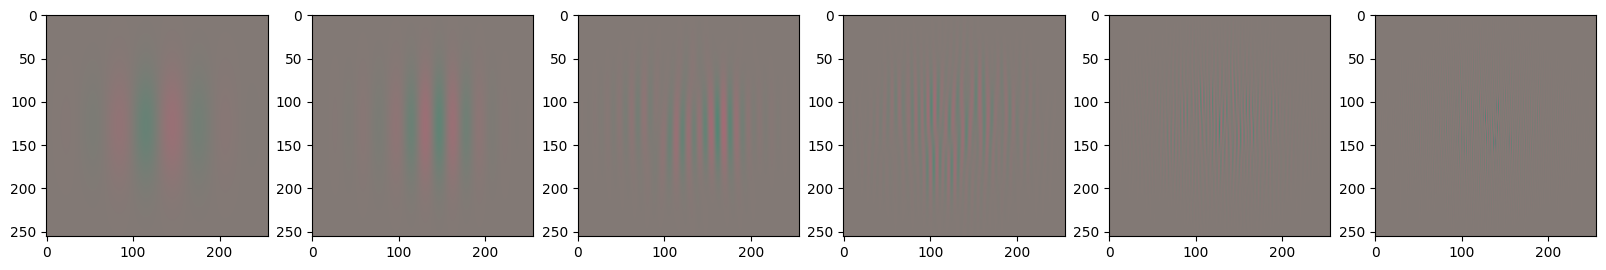

In [ ]:
fig, ax = plt.subplots(1,len(noises_t), figsize=(20, 9))

for i, noise_ in enumerate(noises_t):
    ax[i].imshow(noise_)
plt.show()

In [ ]:
noises_d_atd, noises_d = create_noises(f_tests=f_tests,
                                   num_rows = 256, 
                                   num_cols = 256,
                                   fs = 64,
                                   L0 = L0,
                                   c_noises = c_noises,
                                   color_noise = np.array([0, 0, 1])[None,:],
                                   gs = g,
                                   delta_angle=7)
noises_d.shape, noises_d_atd.shape

((6, 256, 256, 3), (6, 256, 256, 3))

In [ ]:
((noises_d_atd-bg)**2).sum(axis=(1,2))**(1/2)

array([[  0.        ,   0.        , 304.11248445],
       [  0.        ,   0.        , 304.11248445],
       [  0.        ,   0.        , 304.11248445],
       [  0.        ,   0.        , 304.11248445],
       [  0.        ,   0.        , 304.11248445],
       [  0.        ,   0.        , 304.11248445]])

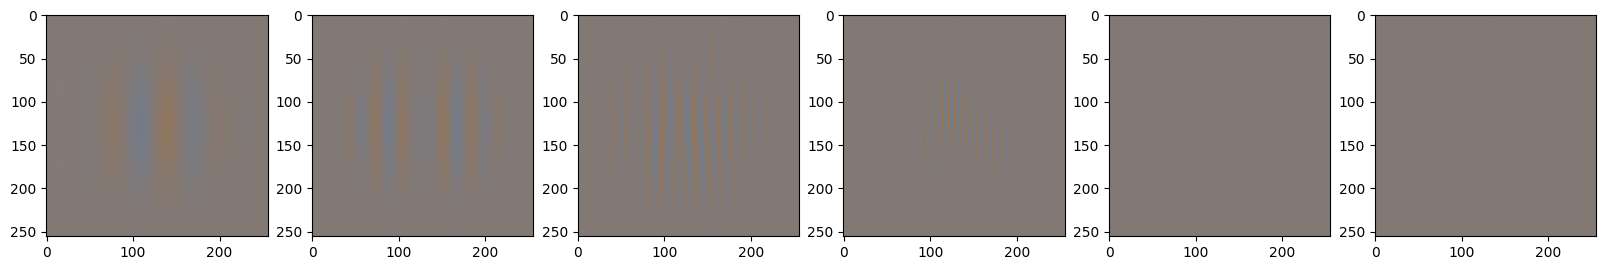

In [ ]:
fig, ax = plt.subplots(1,len(noises_d), figsize=(20, 9))

for i, noise_ in enumerate(noises_d):
    ax[i].imshow(noise_)
plt.show()

In [ ]:
def obtain_csf_iteratively(freqs, iterations, color_noise, background):
    visses_gabors, visses_gabors_rot, visses_noises = [], [], []
    rotations = []
    for i in range(iterations):
        ## Generate gabors
        gabors_atd, gabors = create_gabors_gs(f_tests=freqs,
                                            phase=np.random.uniform(0, 2*np.pi),
                                            num_rows = 256, 
                                            num_cols = 256,
                                            fs = 64,
                                            L0 = L0,
                                            c_noises = c_noises,
                                            color_noise = color_noise,
                                            gs = g)
        rotation = np.random.uniform(0, 2*np.pi)
        gabors_atd_rot, gabors_rot = create_gabors_gs(f_tests=freqs,
                                            phase=np.random.uniform(0, 2*np.pi),
                                            angle=rotation,
                                            num_rows = 256, 
                                            num_cols = 256,
                                            fs = 64,
                                            L0 = L0,
                                            c_noises = c_noises,
                                            color_noise = color_noise,
                                            gs = g)
        ## Generate noises
        noises_atd, noises = create_noises(f_tests=freqs,
                                        L0 = L0,
                                        c_noises = c_noises,
                                        color_noise = color_noise,
                                        gs = g)
        ## Get readouts
        pred_gabors = model.predict(gabors)
        vis_gabors = (pred_gabors-pred_background)**2
        vis_gabors = np.sqrt(np.sum(vis_gabors.reshape(gabors.shape[0],-1), axis=-1))

        pred_gabors_rot = model.predict(gabors_rot)
        vis_gabors_rot = (pred_gabors_rot-pred_background)**2
        vis_gabors_rot = np.sqrt(np.sum(vis_gabors_rot.reshape(gabors_rot.shape[0],-1), axis=-1))

        pred_noises = model.predict(noises)
        vis_noises = (pred_noises-pred_background)**2
        vis_noises = np.sqrt(np.sum(vis_noises.reshape(noises.shape[0],-1), axis=-1))

        ## Store them
        visses_gabors.append(vis_gabors)
        visses_gabors_rot.append(vis_gabors_rot)
        rotations.append(rotation)
        visses_noises.append(vis_noises)
        
    ## Return them as np.arrays
    return np.array(visses_gabors), np.array(visses_gabors_rot), np.array(visses_noises)

In [ ]:
IMG_SHAPE = (384,512,3)

In [ ]:
def control_lum_contrast(image, L, C):
    # CONTROL_LUM_CONTRAST sets the average luminance and RMSE sinus-like contrast for a natural image 
    img_mean = jnp.mean(image)
    img_std = jnp.std(image)*jnp.sqrt(2)
    if img_std == 0:
        img_std = 1
    new_image = (image - img_mean)/img_std
    new_image = L + C*L*new_image
    return new_image

In [ ]:
id = "lh28wqlk"

In [ ]:
api = wandb.Api()
prev_run = api.run(f"jorgvt/PerceptNet_v15/{id}")

In [ ]:
config = ConfigDict(prev_run.config["_fields"])

In [ ]:
for file in prev_run.files():
    file.download(root=prev_run.dir, replace=True)

## Define the model we're going to use

> It's going to be a very simple model just for demonstration purposes.

In [ ]:
class GDNSpatioFreqOrient(nn.Module):
    """Generalized Divisive Normalization."""
    kernel_size: Union[int, Sequence[int]]
    strides: int = 1
    padding: str = "SAME"
    # inputs_star: float = 1.
    # outputs_star: Union[None, float] = None
    fs: int = 1
    apply_independently: bool = False
    bias_init: Callable = nn.initializers.ones_init()
    alpha: float = 2.
    epsilon: float = 1/2 # Exponential of the denominator
    eps: float = 1e-6 # Numerical stability in the denominator

    @nn.compact
    def __call__(self,
                 inputs,
                 fmean,
                 theta_mean,
                 train=False,
                 ):
        b, h, w, c = inputs.shape
        bias = self.param("bias",
                          #equal_to(inputs_star/10),
                          self.bias_init,
                          (c,))
        # is_initialized = self.has_variable("batch_stats", "inputs_star")
        # inputs_star = self.variable("batch_stats", "inputs_star", lambda x: jnp.ones(x)*self.inputs_star, (len(self.inputs_star),))
        # inputs_star_ = jnp.ones_like(inputs)*inputs_star.value
        GL = GaussianLayerGamma(features=c, kernel_size=self.kernel_size, strides=self.strides, padding="VALID", fs=self.fs, xmean=self.kernel_size/self.fs/2, ymean=self.kernel_size/self.fs/2, normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, use_bias=False, feature_group_count=c)
        FG = FreqGaussianGamma()
        OG = OrientGaussianGamma()
        outputs = GL(pad_same_from_kernel_size(inputs, kernel_size=self.kernel_size, mode=self.padding)**self.alpha, train=train)#/(self.kernel_size**2)
        outputs = FG(outputs, fmean=fmean)
        ## Reshape so that the orientations are the innermost dimmension
        outputs = rearrange(outputs, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        outputs = OG(outputs, theta_mean=theta_mean)
        ## Recover original disposition
        denom = rearrange(outputs, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)

        ## Coef
        # coef = GL(inputs_star_**self.alpha, train=train)#/(self.kernel_size**2)
        # coef = FG(coef, fmean=fmean)
        # coef = rearrange(coef, "b h w (phase theta f) -> b h w (phase f theta)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = OG(coef, theta_mean=theta_mean) + bias
        # coef = rearrange(coef, "b h w (phase f theta) -> b h w (phase theta f)", b=b, h=h, w=w, phase=2, f=config.N_SCALES, theta=config.N_ORIENTATIONS)
        # coef = jnp.clip(coef+bias, a_min=1e-5)**self.epsilon
        # # coef = inputs_star.value * coef
        # if self.outputs_star is not None: coef = coef/inputs_star.value*self.outputs_star

        # if is_initialized and train:
        #     inputs_star.value = (inputs_star.value + jnp.quantile(jnp.abs(inputs), q=0.95, axis=(0,1,2)))/2
        # return coef * inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)
        return inputs / (jnp.clip(denom+bias, a_min=1e-5)**self.epsilon + self.eps)

In [ ]:
class PerceptNet(nn.Module):
    """IQA model inspired by the visual system."""

    @nn.compact
    def __call__(self,
                 inputs, # Assuming fs = 128 (cpd)
                 **kwargs,
                 ):
        ## (Independent) Color equilibration (Gamma correction)
        ## Might need to be the same for each number
        ## bias = 0.1 / kernel = 0.5
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(inputs)
        
        ## Color (ATD) Transformation
        outputs = nn.Conv(features=3, kernel_size=(1,1), use_bias=False)(outputs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))
        
        ## GDN Star A - T - D [Separated]
        outputs = GDN(kernel_size=(1,1), apply_independently=True)(outputs)

        ## Center Surround (DoG)
        ## Initialized so that 3 are positives and 3 are negatives and no interaction between channels is present
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.CS_KERNEL_SIZE, mode="symmetric")
        outputs = CenterSurroundLogSigmaK(features=3, kernel_size=config.CS_KERNEL_SIZE, fs=21, use_bias=False, padding="VALID")(outputs, **kwargs)
        outputs = nn.max_pool(outputs, window_shape=(2,2), strides=(2,2))

        ## GDN per channel with mean substraction in T and D (Spatial Gaussian Kernel)
        ### fs = 32 / kernel_size = (11,11) -> 0.32 > 0.02 --> OK!
        ## TO-DO: - Spatial Gaussian Kernel (0.02 deg) -> fs = 64/2 & 0.02*64/2 = sigma (px) = 0.69
        outputs = GDNGaussian(kernel_size=config.GDNGAUSSIAN_KERNEL_SIZE, apply_independently=True, fs=32, padding="symmetric", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY)(outputs, **kwargs)

        ## GaborLayer per channel with GDN mixing only same-origin-channel information
        ### [Gaussian] sigma = 0.2 (deg) fs = 32 / kernel_size = (21,21) -> 21/32 = 0.66 --> OK!
        outputs = pad_same_from_kernel_size(outputs, kernel_size=config.GABOR_KERNEL_SIZE, mode="symmetric")
        outputs, fmean, theta_mean = GaborLayerLogSigma_(n_scales=config.N_SCALES, n_orientations=config.N_ORIENTATIONS, kernel_size=config.GABOR_KERNEL_SIZE, fs=32, xmean=config.GABOR_KERNEL_SIZE/32/2, ymean=config.GABOR_KERNEL_SIZE/32/2, strides=1, padding="VALID", normalize_prob=config.NORMALIZE_PROB, normalize_energy=config.NORMALIZE_ENERGY, zero_mean=config.ZERO_MEAN, use_bias=config.USE_BIAS)(outputs, return_freq=True, return_theta=True, **kwargs)
        
        ## Final GDN mixing Gabor information (?)
        outputs = GDNSpatioFreqOrient(kernel_size=21, strides=1, padding="symmetric", fs=32, apply_independently=False)(outputs, fmean=fmean, theta_mean=theta_mean, **kwargs)
        # outputs = GDN(kernel_size=(1,1), apply_independently=False)(outputs)
        return outputs

## Define the metrics with `clu`

In [ ]:
@struct.dataclass
class Metrics(metrics.Collection):
    """Collection of metrics to be tracked during training."""
    loss: metrics.Average.from_output("loss")

By default, `TrainState` doesn't include metrics, but it's very easy to subclass it so that it does:

In [ ]:
class TrainState(train_state.TrainState):
    metrics: Metrics
    state: FrozenDict

We'll define a function that initializes the `TrainState` from a module, a rng key and some optimizer:

In [ ]:
def create_train_state(module, key, tx, input_shape):
    """Creates the initial `TrainState`."""
    variables = module.init(key, jnp.ones(input_shape))
    state, params = variables.pop('params')
    return TrainState.create(
        apply_fn=module.apply,
        params=params,
        state=state,
        tx=tx,
        metrics=Metrics.empty()
    )

## Defining the training step

> We want to write a function that takes the `TrainState` and a batch of data can performs an optimization step.

In [ ]:
def pearson_correlation(vec1, vec2):
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    vec1_mean = vec1.mean()
    vec2_mean = vec2.mean()
    num = vec1-vec1_mean
    num *= vec2-vec2_mean
    num = num.sum()
    denom = jnp.sqrt(jnp.sum((vec1-vec1_mean)**2))
    denom *= jnp.sqrt(jnp.sum((vec2-vec2_mean)**2))
    return num/denom

In [ ]:
@jax.jit
def train_step(state, batch):
    """Train for a single step."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=True)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=True)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos), updated_state
    
    (loss, updated_state), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
    state = state.apply_gradients(grads=grads)
    metrics_updates = state.metrics.single_from_model_output(loss=loss)
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    state = state.replace(state=updated_state)
    return state

In their example, they don't calculate the metrics at the same time. I think it is kind of a waste because it means having to perform a new forward pass, but we'll follow as of now. Let's define a function to perform metric calculation:

In [ ]:
@jax.jit
def compute_metrics(*, state, batch):
    """Obtaining the metrics for a given batch."""
    img, img_dist, mos = batch
    def loss_fn(params):
        ## Forward pass through the model
        img_pred, updated_state = state.apply_fn({"params": params, **state.state}, img, mutable=list(state.state.keys()), train=False)
        img_dist_pred, updated_state = state.apply_fn({"params": params, **state.state}, img_dist, mutable=list(state.state.keys()), train=False)

        ## Calculate the distance
        dist = ((img_pred - img_dist_pred)**2).sum(axis=(1,2,3))**(1/2)
        
        ## Calculate pearson correlation
        return pearson_correlation(dist, mos)
    
    metrics_updates = state.metrics.single_from_model_output(loss=loss_fn(state.params))
    metrics = state.metrics.merge(metrics_updates)
    state = state.replace(metrics=metrics)
    return state

## Loading the weights

In [ ]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), optax.adam(config.LEARNING_RATE), input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

In [ ]:
import flax

In [ ]:
def check_trainable(path):
    return False
    # return ("A" in path) or ("alpha_achrom" in path) or ("alpha_chrom_rg" in path) or ("alpha_chrom_yb" in path)

In [ ]:
trainable_tree = freeze(flax.traverse_util.path_aware_map(lambda path, v: "non_trainable" if check_trainable(path)  else "trainable", state.params))

In [ ]:
optimizers = {
    "trainable": optax.adam(learning_rate=config.LEARNING_RATE),
    "non_trainable": optax.set_to_zero(),
}

In [ ]:
tx = optax.multi_transform(optimizers, trainable_tree)

In [ ]:
state = create_train_state(PerceptNet(), random.PRNGKey(config.SEED), tx, input_shape=(1,384,512,3))
# state = state.replace(params=clip_layer(state.params, "GDN", a_min=0))

Instantiate the checkpointer to reload the already trained model:

In [ ]:
orbax_checkpointer = orbax.checkpoint.PyTreeCheckpointer()
save_args = orbax_utils.save_args_from_target(state)

In [ ]:
state = orbax_checkpointer.restore(f"{prev_run.dir}/model-best", item=state)

In [ ]:
param_count = sum(x.size for x in jax.tree_util.tree_leaves(state.params))
param_count

289

## Forward pass of the generated stimuli

In [ ]:
from functools import partial

In [ ]:
@jax.jit
def forward(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False)

In [ ]:
@jax.jit
def forward_intermediates(state, inputs):
    return state.apply_fn({"params": state.params, **state.state}, inputs, train=False, capture_intermediates=True)

In [ ]:
def filter_extra(extra):
    def filter_intermediates(path, x):
        path = "/".join(path)
        if "Gabor" in path:
            return (x[0][0],)
        else: 
            return x
    extra = unfreeze(extra)
    extra["intermediates"] = flax.traverse_util.path_aware_map(filter_intermediates, extra["intermediates"])
    return freeze(extra)

In [ ]:
def outputs_noises_iterations(n_iters=1,
                              channel="a",
                              ):
    
    ## Check color
    channel = channel.lower()
    if channel=="a": color_noise = np.array([1, 0, 0])[None,:]
    elif channel=="t": color_noise = np.array([0, 1, 0])[None,:]
    elif channel=="d": color_noise = np.array([0, 0, 1])[None,:]
    else: raise ValueError("channel value not supported. Must be either 'a', 't' or 'd'")

    ## Loop over number of repetitions
    outputs_diffs_ = []
    for it in range(n_iters):
        ### Generate stimuli
        noises_atd, noises = create_noises(f_tests=f_tests,
                                    num_rows = 256, 
                                    num_cols = 256,
                                    fs = 64,
                                    L0 = L0,
                                    c_noises = c_noises,
                                    color_noise = color_noise,
                                    gs = g,
                                    delta_angle=7)
        
        ### Generate background
        bg_img = np.ones_like(noises)*noises[:,0:1,0:1,0:1]

        ### Forward pass of both
        outputs_bg, extras_bg = forward_intermediates(state, bg_img)
        extras_bg = filter_extra(extras_bg)
        outputs, extras = forward_intermediates(state, noises)
        extras = filter_extra(extras)
        
        ### Calculate difference between background and stimuli
        outputs_bg_diffs = jax.tree_util.tree_map(lambda x,y: jnp.sum((x-y)**2, axis=(1,2,3))**(1/2), extras["intermediates"], extras_bg["intermediates"])
        outputs_diffs_.append(outputs_bg_diffs)
    
    return outputs_diffs_

In [331]:
a = outputs_noises_iterations(n_iters=7, channel="a")
d = outputs_noises_iterations(n_iters=7, channel="t")
t = outputs_noises_iterations(n_iters=7, channel="d")

In [332]:
means_a = jax.tree_util.tree_map(lambda *vals: jnp.mean(jnp.array(vals), axis=0), *a)
stds_a = jax.tree_util.tree_map(lambda *vals: jnp.std(jnp.array(vals), axis=0), *a)

means_t = jax.tree_util.tree_map(lambda *vals: jnp.mean(jnp.array(vals), axis=0), *t)
stds_t = jax.tree_util.tree_map(lambda *vals: jnp.std(jnp.array(vals), axis=0), *t)

means_d = jax.tree_util.tree_map(lambda *vals: jnp.mean(jnp.array(vals), axis=0), *d)
stds_d = jax.tree_util.tree_map(lambda *vals: jnp.std(jnp.array(vals), axis=0), *d)

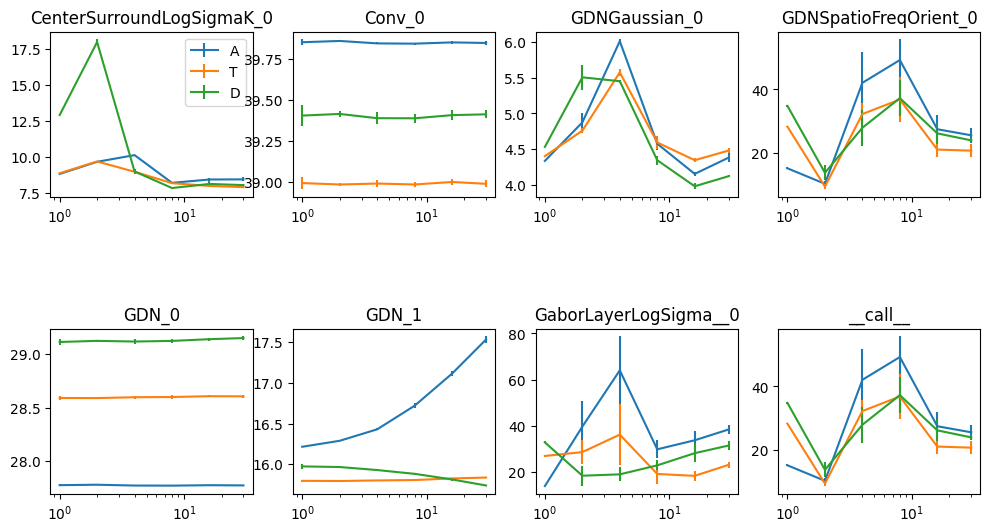

In [333]:
plt.figure(figsize=(12,6))
i = 1
for (k_a, v_a_mean), (k_a, v_a_std), (k_t, v_t_mean), (k_t, v_t_std), (k_d, v_d_mean), (k_d, v_d_std) in zip(flax.traverse_util.flatten_dict(means_a).items(),
                                                                                                             flax.traverse_util.flatten_dict(stds_a).items(),
                                                                                                             flax.traverse_util.flatten_dict(means_t).items(),
                                                                                                             flax.traverse_util.flatten_dict(stds_t).items(),
                                                                                                             flax.traverse_util.flatten_dict(means_d).items(),
                                                                                                             flax.traverse_util.flatten_dict(stds_d).items()):
    if len(k_a) > 2: continue
    plt.subplot(2,4,i)
    plt.title(k_a[0])
    plt.errorbar(f_tests, v_a_mean[0], yerr=v_a_std[0], label="A")
    plt.errorbar(f_tests, v_t_mean[0], yerr=v_t_std[0], label="T")
    plt.errorbar(f_tests, v_d_mean[0], yerr=v_d_std[0], label="D")
    # plt.ylim([0,90])
    plt.xscale("log")
    if i == 1: plt.legend()
    i += 1
    # break

plt.subplots_adjust(hspace=0.8)
plt.show()

## Checking the weights

In [54]:
state.params.keys()

frozen_dict_keys(['CenterSurroundLogSigmaK_0', 'Conv_0', 'GDNGaussian_0', 'GDNSpatioFreqOrient_0', 'GDN_0', 'GDN_1', 'GaborLayerLogSigma__0'])

### Gamma Correction

In [55]:
layer_name = "GDN_0"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([0.38925037, 0.20107375, 0.5490812 ], dtype=float32),
        kernel: array([[[[0.00190776, 0.        , 0.        ]]]], dtype=float32),
    },
})

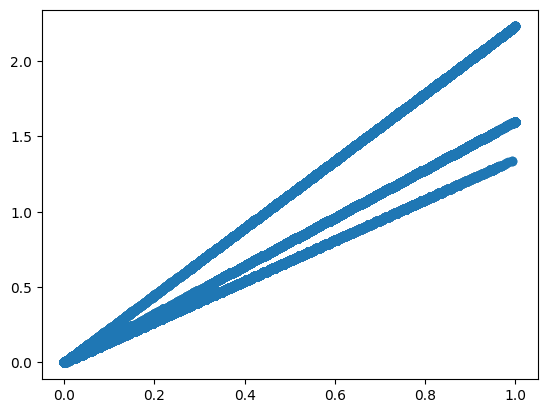

In [56]:
plt.scatter(kk.ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

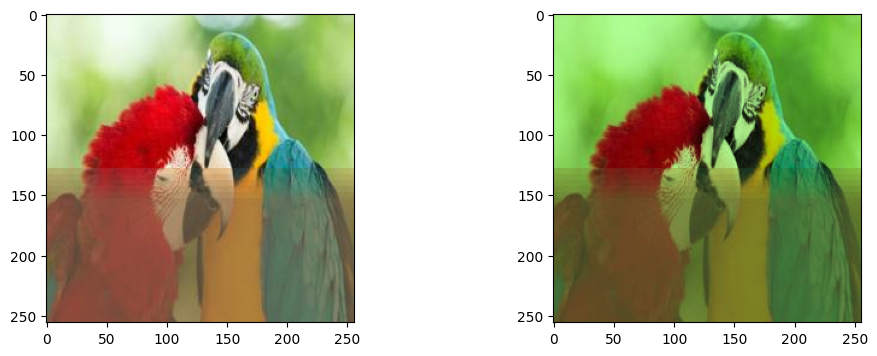

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(12,4))
axes[0].imshow(kk[0])
axes[1].imshow(extras["intermediates"][layer_name]["__call__"][0][0]/extras["intermediates"][layer_name]["__call__"][0][0].max())
plt.show()

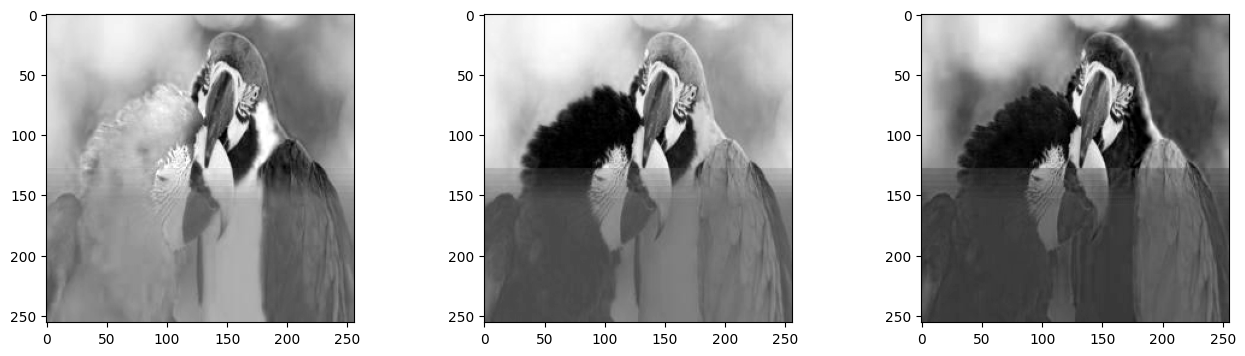

In [58]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### J & H

In [59]:
prev_layer = "GDN_0"
layer_name = "Conv_0"

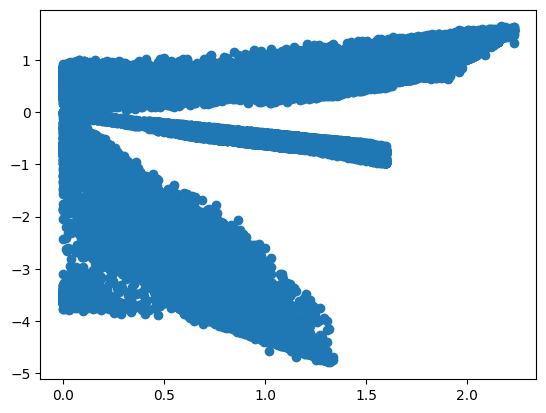

In [60]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

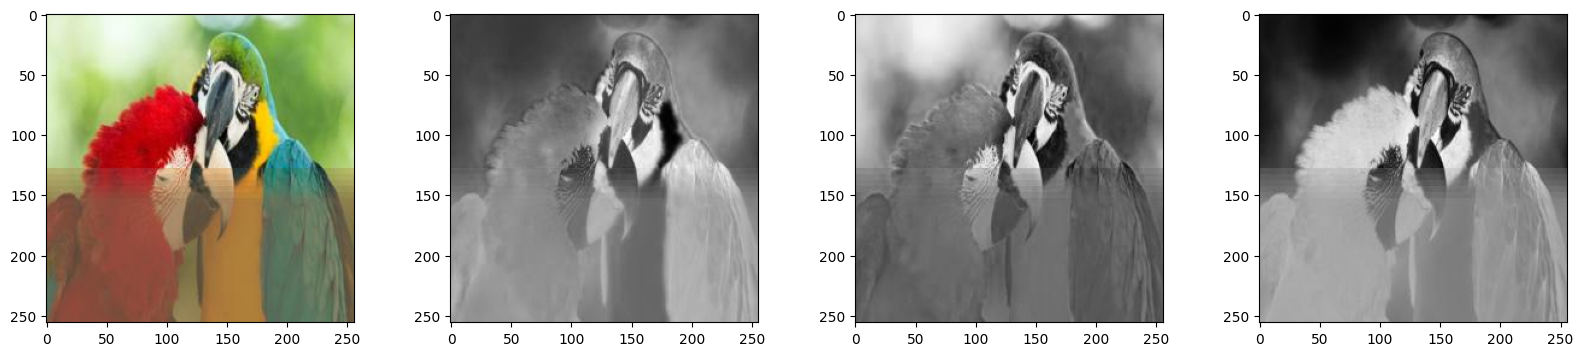

In [61]:
fig, axes = plt.subplots(1, 4, figsize=(20,4))
axes[0].imshow(kk[0])
for i, ax in enumerate(axes[1:]):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0,:,:,i], cmap="gray")
plt.show()

### DN 1

In [62]:
prev_layer = "Conv_0"
layer_name = "GDN_1"
state.params[layer_name]

FrozenDict({
    Conv_0: {
        bias: array([1.1060609, 1.2208902, 1.5628086], dtype=float32),
        kernel: array([[[[0.00440522, 0.00679445, 0.        ]]]], dtype=float32),
    },
})

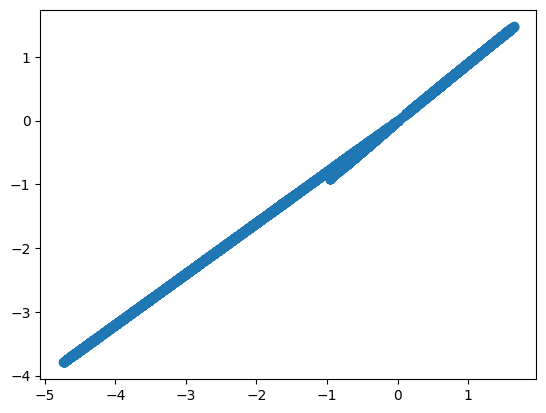

In [63]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

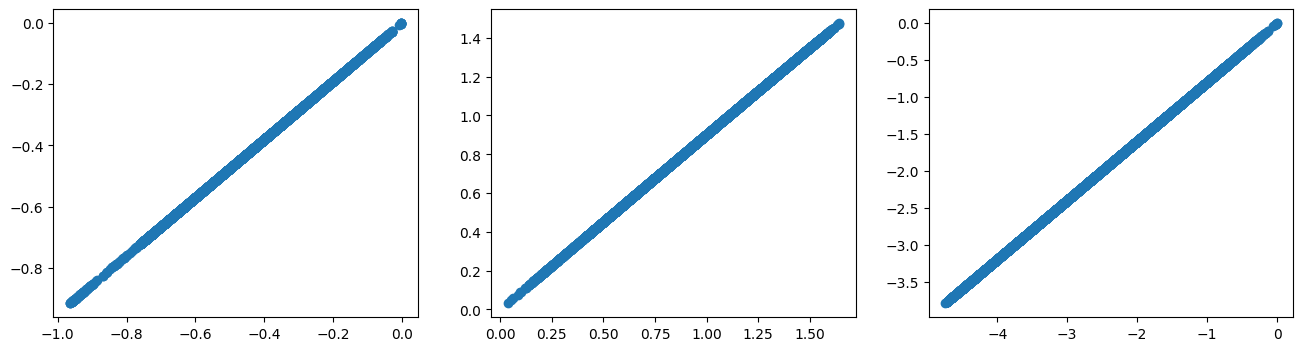

In [64]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

### CSF (DoG)

In [65]:
prev_layer = "GDN_1"
layer_name = "CenterSurroundLogSigmaK_0"
state.params[layer_name]

FrozenDict({
    A: array([0.9253089 , 0.02978062, 0.00456703, 0.        , 0.9095068 ,
           0.06897642, 0.25970432, 0.2958175 , 0.37848508], dtype=float32),
    K: array([1.0045615, 1.092639 , 1.0172168, 1.071168 , 1.1869099, 1.1209534,
           1.0028659, 1.001905 , 1.0582001], dtype=float32),
    logsigma: array([-2.5491529 , -2.7412858 , -2.4752436 , -2.247451  , -1.7427999 ,
           -0.28585312, -2.635996  , -1.9763094 , -2.3531847 ], dtype=float32),
})

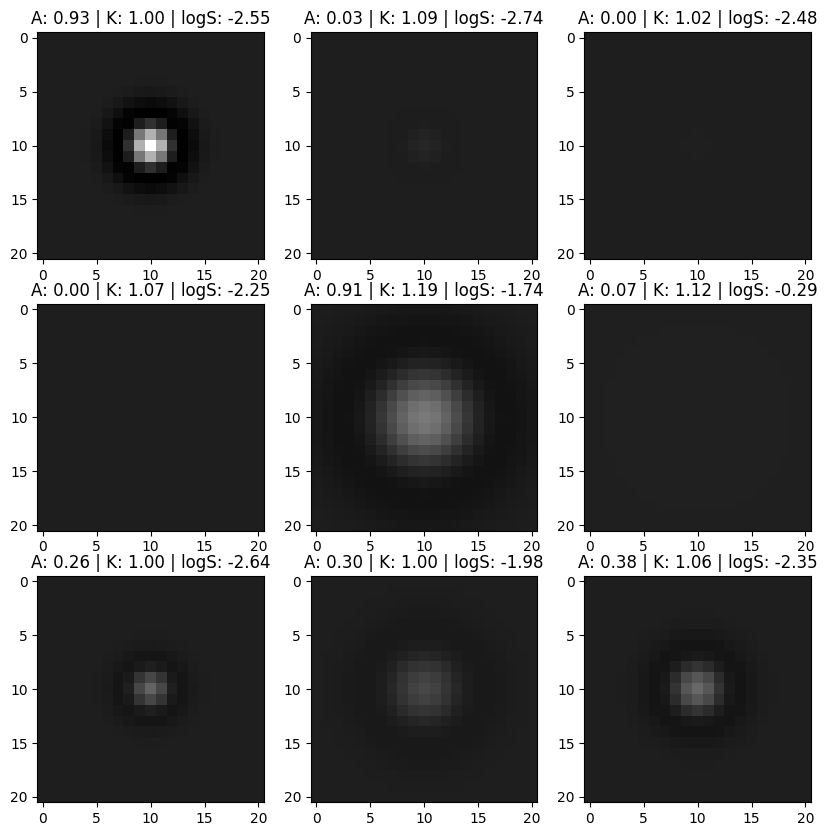

In [66]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

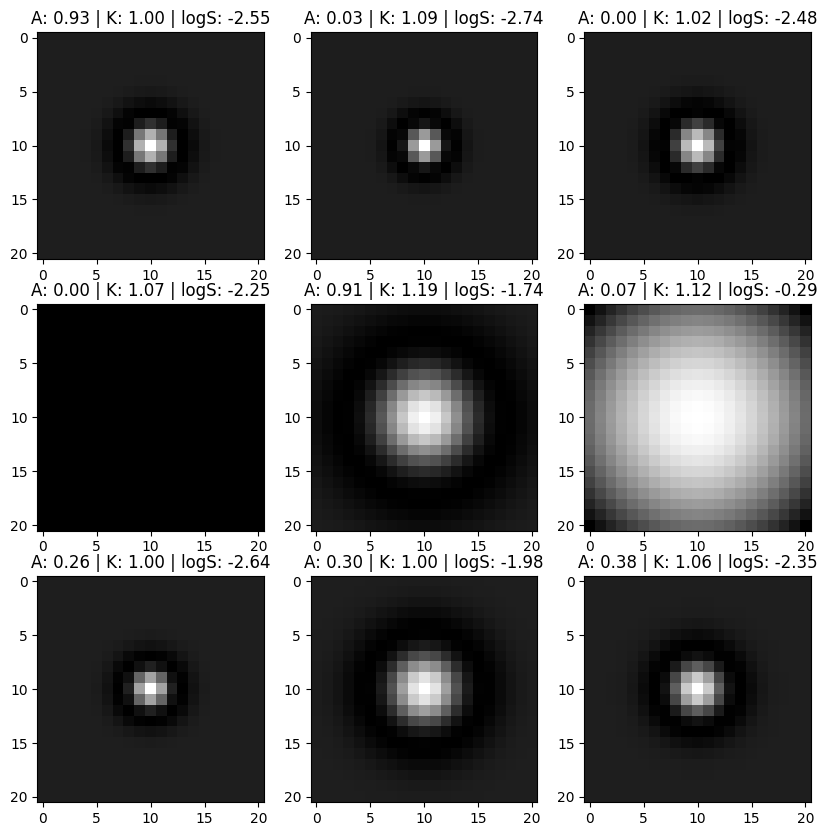

In [67]:
fig, axes = plt.subplots(3, 3, figsize=(10,10))
m, M = state.state["precalc_filter"][layer_name]["kernel"].min(), state.state["precalc_filter"][layer_name]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,i,j], cmap="gray")
        ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### DN (2)

In [68]:
prev_layer = "CenterSurroundLogSigmaK_0"
layer_name = "GDNGaussian_0"
state.params[layer_name]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([2.8993428 , 0.91962445, 0.00439308], dtype=float32),
        bias: array([0.19889925, 0.15775032, 0.60464966], dtype=float32),
        gamma: array([31.549963, 30.471186, 29.703917], dtype=float32),
    },
})

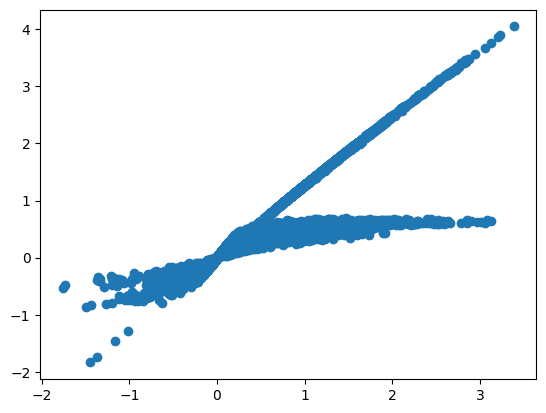

In [69]:
plt.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2)).ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

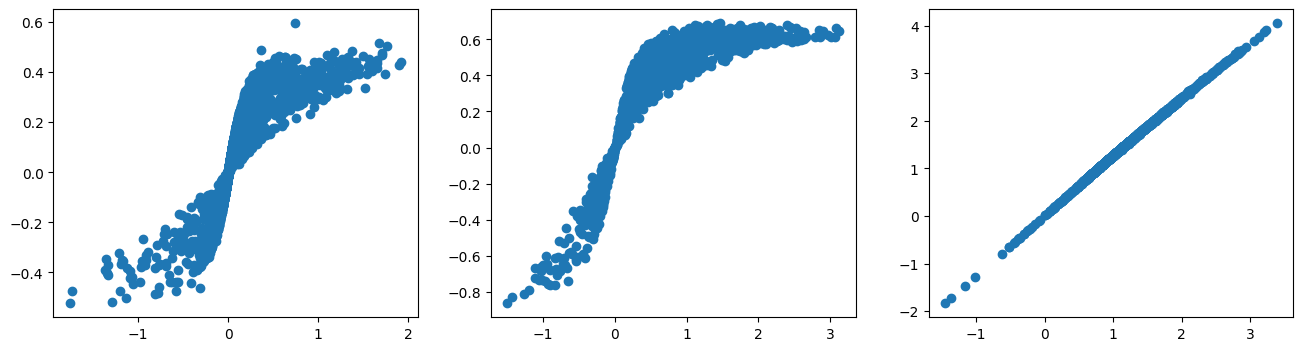

In [70]:
fig, axes = plt.subplots(1, 3, figsize=(16,4))
for i, ax in enumerate(axes):
    ax.scatter(nn.max_pool(extras["intermediates"][prev_layer]["__call__"][0], window_shape=(2,2), strides=(2,2))[0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()

In [71]:
state.params["GDNGaussian_0"]

FrozenDict({
    GaussianLayerGamma_0: {
        A: array([2.8993428 , 0.91962445, 0.00439308], dtype=float32),
        bias: array([0.19889925, 0.15775032, 0.60464966], dtype=float32),
        gamma: array([31.549963, 30.471186, 29.703917], dtype=float32),
    },
})

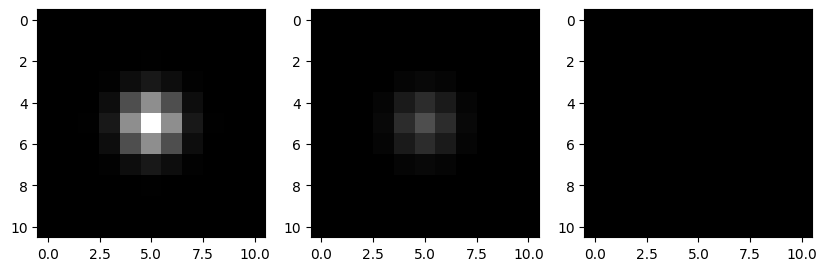

In [72]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], vmin=m, vmax=M, cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

In [73]:
state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,0].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,1].sum(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,0,2].sum()

(9.471365, 3.1115837, 0.014315877)

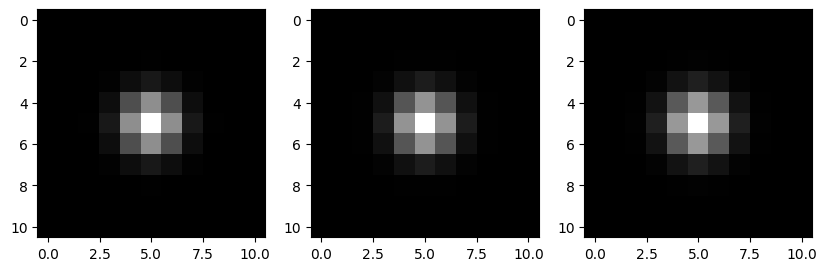

In [74]:
fig, axes = plt.subplots(1, 3, figsize=(10,10), squeeze=False)
m, M = state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].min(), state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"].max()
k = 0
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.imshow(state.state["precalc_filter"][layer_name]["GaussianLayerGamma_0"]["kernel"][:,:,i,j], cmap="gray")
        # ax.set_title(f'A: {state.params[layer_name]["A"][k]:.2f} | K: {state.params[layer_name]["K"][k]:.2f} | logS: {state.params[layer_name]["logsigma"][k]:.2f}')
        k += 1
plt.show()

### Gabor

In [75]:
prev_layer = "GDNGaussian_0"
layer_name = "GaborLayerLogSigma__0"
state.params[layer_name]

FrozenDict({
    freq: array([15.2442255,  6.3626275,  3.0863705,  2.3597813], dtype=float32),
    logsigmax2: array([-3.487606  , -2.1883376 , -0.18465832, -3.7266617 ], dtype=float32),
    logsigmay2: array([-2.0215962 , -1.5637778 ,  0.36992815, -2.3085575 ], dtype=float32),
    sigma_theta: array([0.6385669 , 1.3767222 , 0.37266782, 1.0391413 , 2.0386834 ,
           4.369458  , 2.0715668 , 3.9765372 ], dtype=float32),
    theta: array([-0.02563966,  0.47865427,  0.8550752 ,  0.8317699 ,  1.5738049 ,
            2.0358028 ,  2.401357  ,  2.5713036 ], dtype=float32),
})

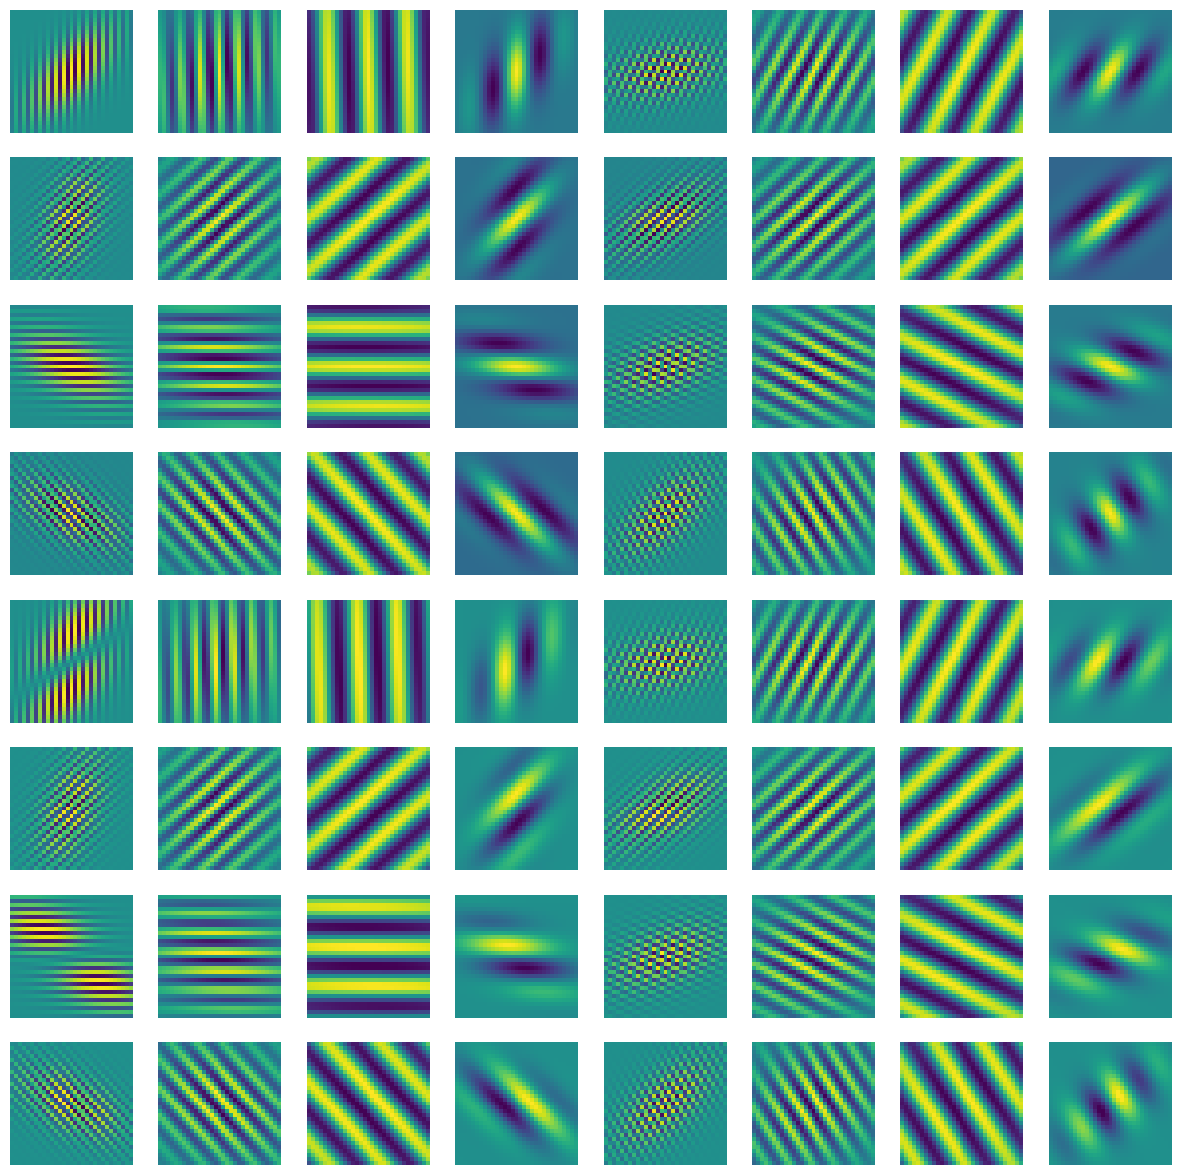

In [76]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"][layer_name]["kernel"][:,:,0,i])
    ax.axis("off")
plt.show()

In [77]:
kernel = state.state["precalc_filter"][layer_name]["kernel"]
kernel.shape

(31, 31, 3, 64)

In [78]:
kernel_f_fft = jnp.fft.fftn(kernel[:,:,0,:], axes=(0,1))
kernel_f_fft = jnp.fft.fftshift(kernel_f_fft)
kernel_f_fft_abs_sum = jnp.abs(kernel_f_fft).sum(axis=-1)
kernel_f_fft.shape, kernel_f_fft_abs_sum.shape

((31, 31, 64), (31, 31))

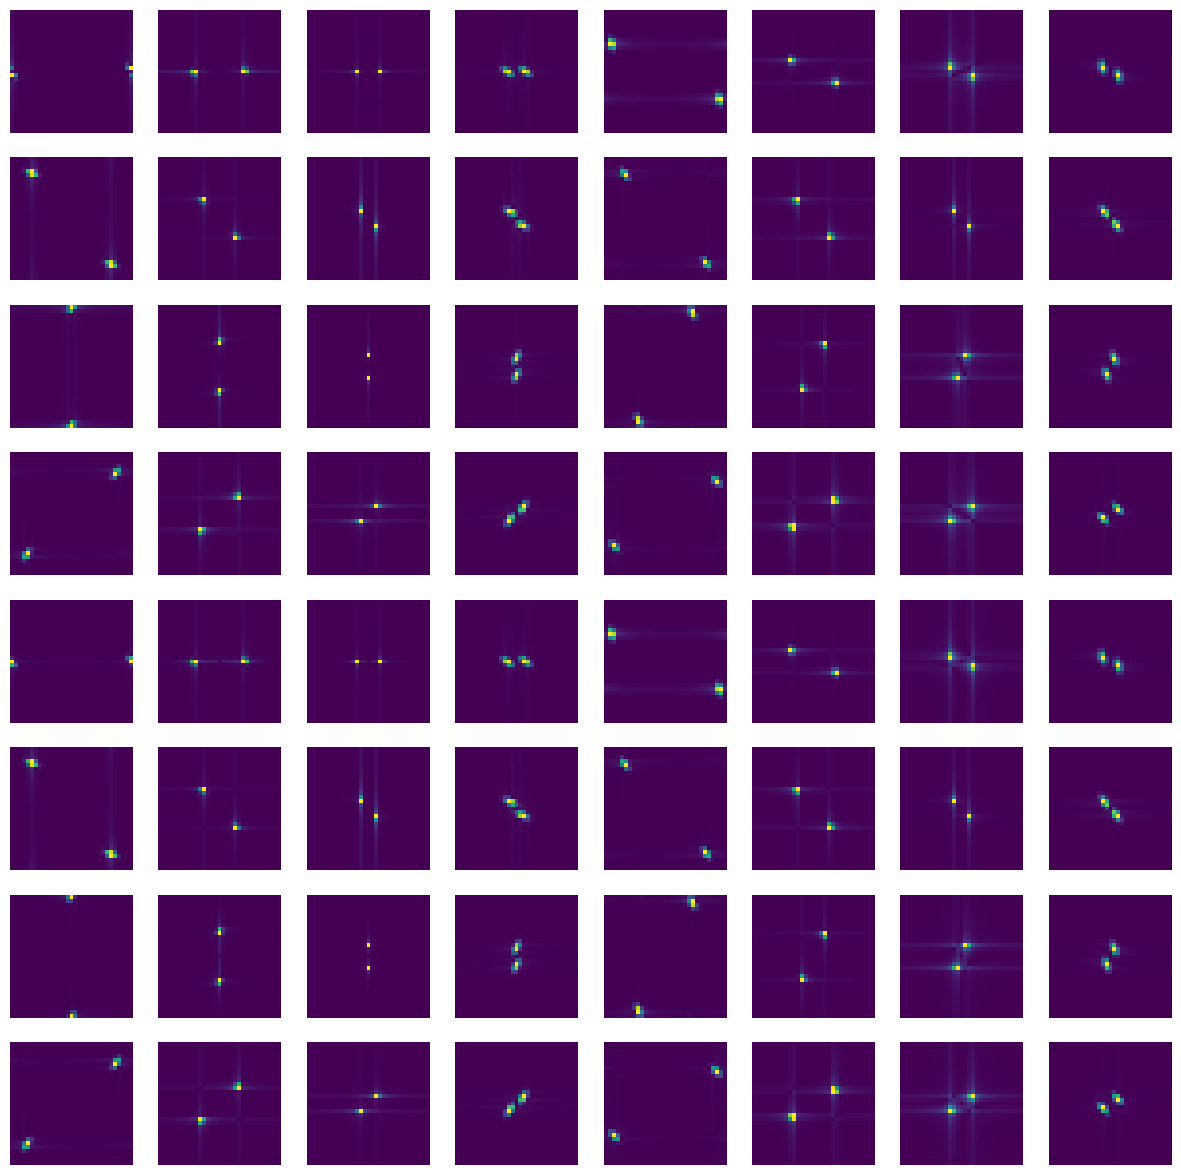

In [79]:
fig, axes = plt.subplots(8,8, figsize=(15,15))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(jnp.abs(kernel_f_fft[:,:,i]))
    ax.axis("off")
plt.show()

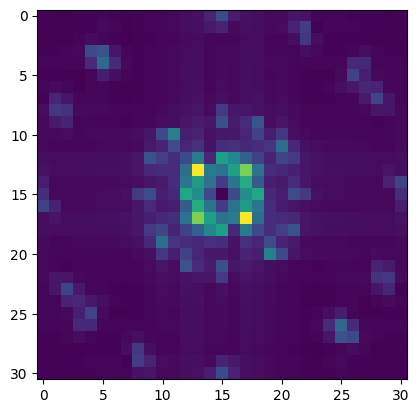

In [80]:
plt.imshow(kernel_f_fft_abs_sum)
plt.show()

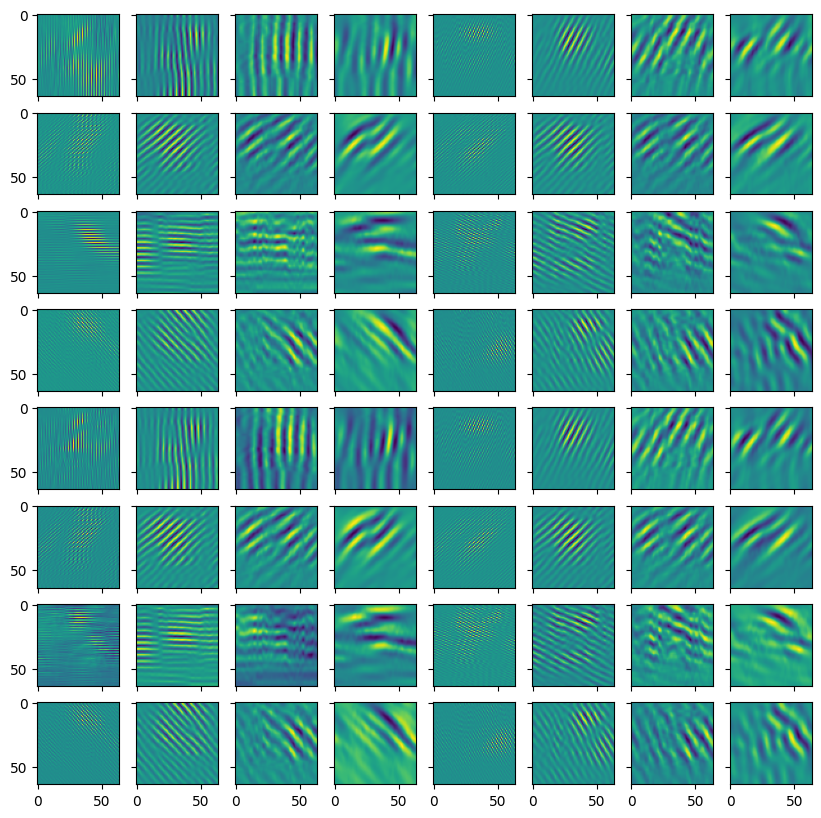

In [81]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.imshow(extras["intermediates"][layer_name]["__call__"][0][0][0,:,:,i])
plt.show()
plt.show()

### DN (3)

In [82]:
prev_layer = "GaborLayerLogSigma__0"
layer_name = "GDNSpatioFreqOrient_0"
state.params[layer_name]

FrozenDict({
    FreqGaussianGamma_0: {
        gamma: array([7.3432237e-01, 2.4220018e-20, 1.4549515e-12, 1.9211438e+00],
              dtype=float32),
    },
    GaussianLayerGamma_0: {
        A: array([1.1848982e-02, 3.6574812e+00, 6.1213412e+00, 2.3372131e-04,
               0.0000000e+00, 0.0000000e+00, 3.4575158e-01, 2.4828443e-03,
               0.0000000e+00, 6.1443553e+00, 1.5713852e-03, 2.3613393e-02,
               1.9086688e+00, 5.7718048e+00, 1.6670132e-03, 6.5055373e-03,
               1.1797952e-01, 1.1043372e-03, 1.1196592e+00, 0.0000000e+00,
               0.0000000e+00, 2.7016428e+00, 0.0000000e+00, 0.0000000e+00,
               0.0000000e+00, 3.3468678e+00, 0.0000000e+00, 0.0000000e+00,
               0.0000000e+00, 5.6102648e+00, 0.0000000e+00, 0.0000000e+00,
               5.3529952e-02, 3.7064722e+00, 7.6731315e+00, 3.0780131e-01,
               0.0000000e+00, 0.0000000e+00, 9.3596828e-01, 1.8163284e-03,
               1.7090533e+00, 6.4547210e+00, 1.6140393e-03,

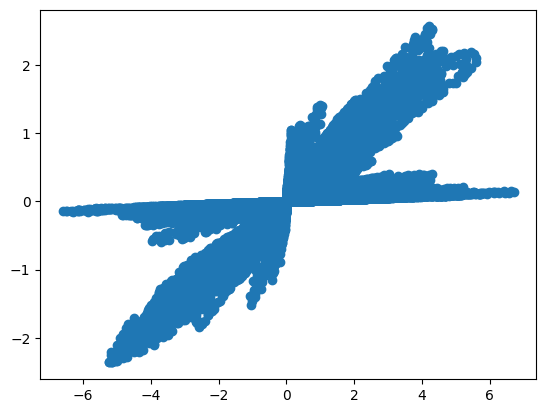

In [83]:
plt.scatter(extras["intermediates"][prev_layer]["__call__"][0][0].ravel(),
            extras["intermediates"][layer_name]["__call__"][0].ravel())
plt.show()

In [84]:
extras["intermediates"][prev_layer]["__call__"][0][0].shape

(1, 64, 64, 64)

In [85]:
fig, axes = plt.subplots(8, 8, figsize=(10,10), sharex=True, sharey=True)
for i, ax in enumerate(axes.ravel()):
    ax.scatter(extras["intermediates"][prev_layer]["__call__"][0][0][0,:,:,i].ravel(),
               extras["intermediates"][layer_name]["__call__"][0][0,:,:,i].ravel())
plt.show()
plt.show()

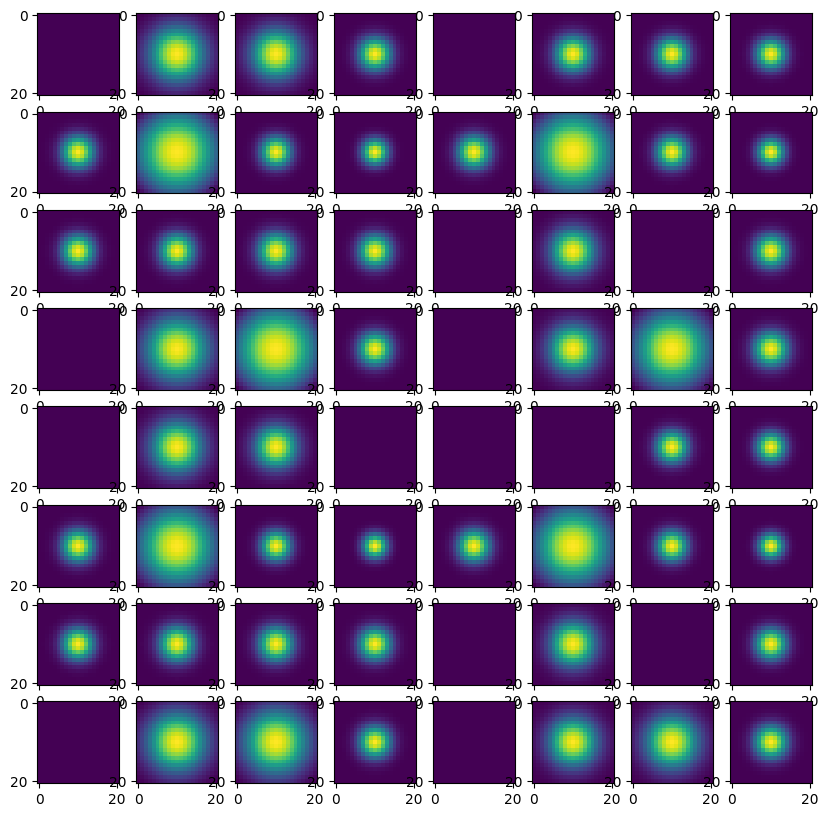

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(10,10))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(state.state["precalc_filter"]["GDNSpatioFreqOrient_0"]["GaussianLayerGamma_0"]["kernel"][:,:,0,i])
plt.show()

In [ ]:
state.params[prev_layer]["freq"]

array([12.956768 ,  8.951702 ,  3.6307886,  2.5035727], dtype=float32)

In [ ]:
1/state.params[layer_name]["FreqGaussianGamma_0"]["gamma"]

array([0.7770788 , 1.874241  , 0.50422704, 0.855238  ], dtype=float32)

In [ ]:
state.params[prev_layer]["theta"]*180/jnp.pi

array([ -1.5666279,  18.059473 ,  52.186398 ,  52.1309   ,  91.32133  ,
       132.70038  , 143.5989   , 153.29633  ], dtype=float32)

In [ ]:
1/state.params[layer_name]["OrientGaussianGamma_0"]["gamma"]

/tmp/uv0752/ipykernel_136148/1286078305.py:1: RuntimeWarning: divide by zero encountered in divide
  1/state.params[layer_name]["OrientGaussianGamma_0"]["gamma"]


array([       inf,        inf, 0.37727603, 0.78083926,        inf,
              inf,        inf,        inf], dtype=float32)

### Final output

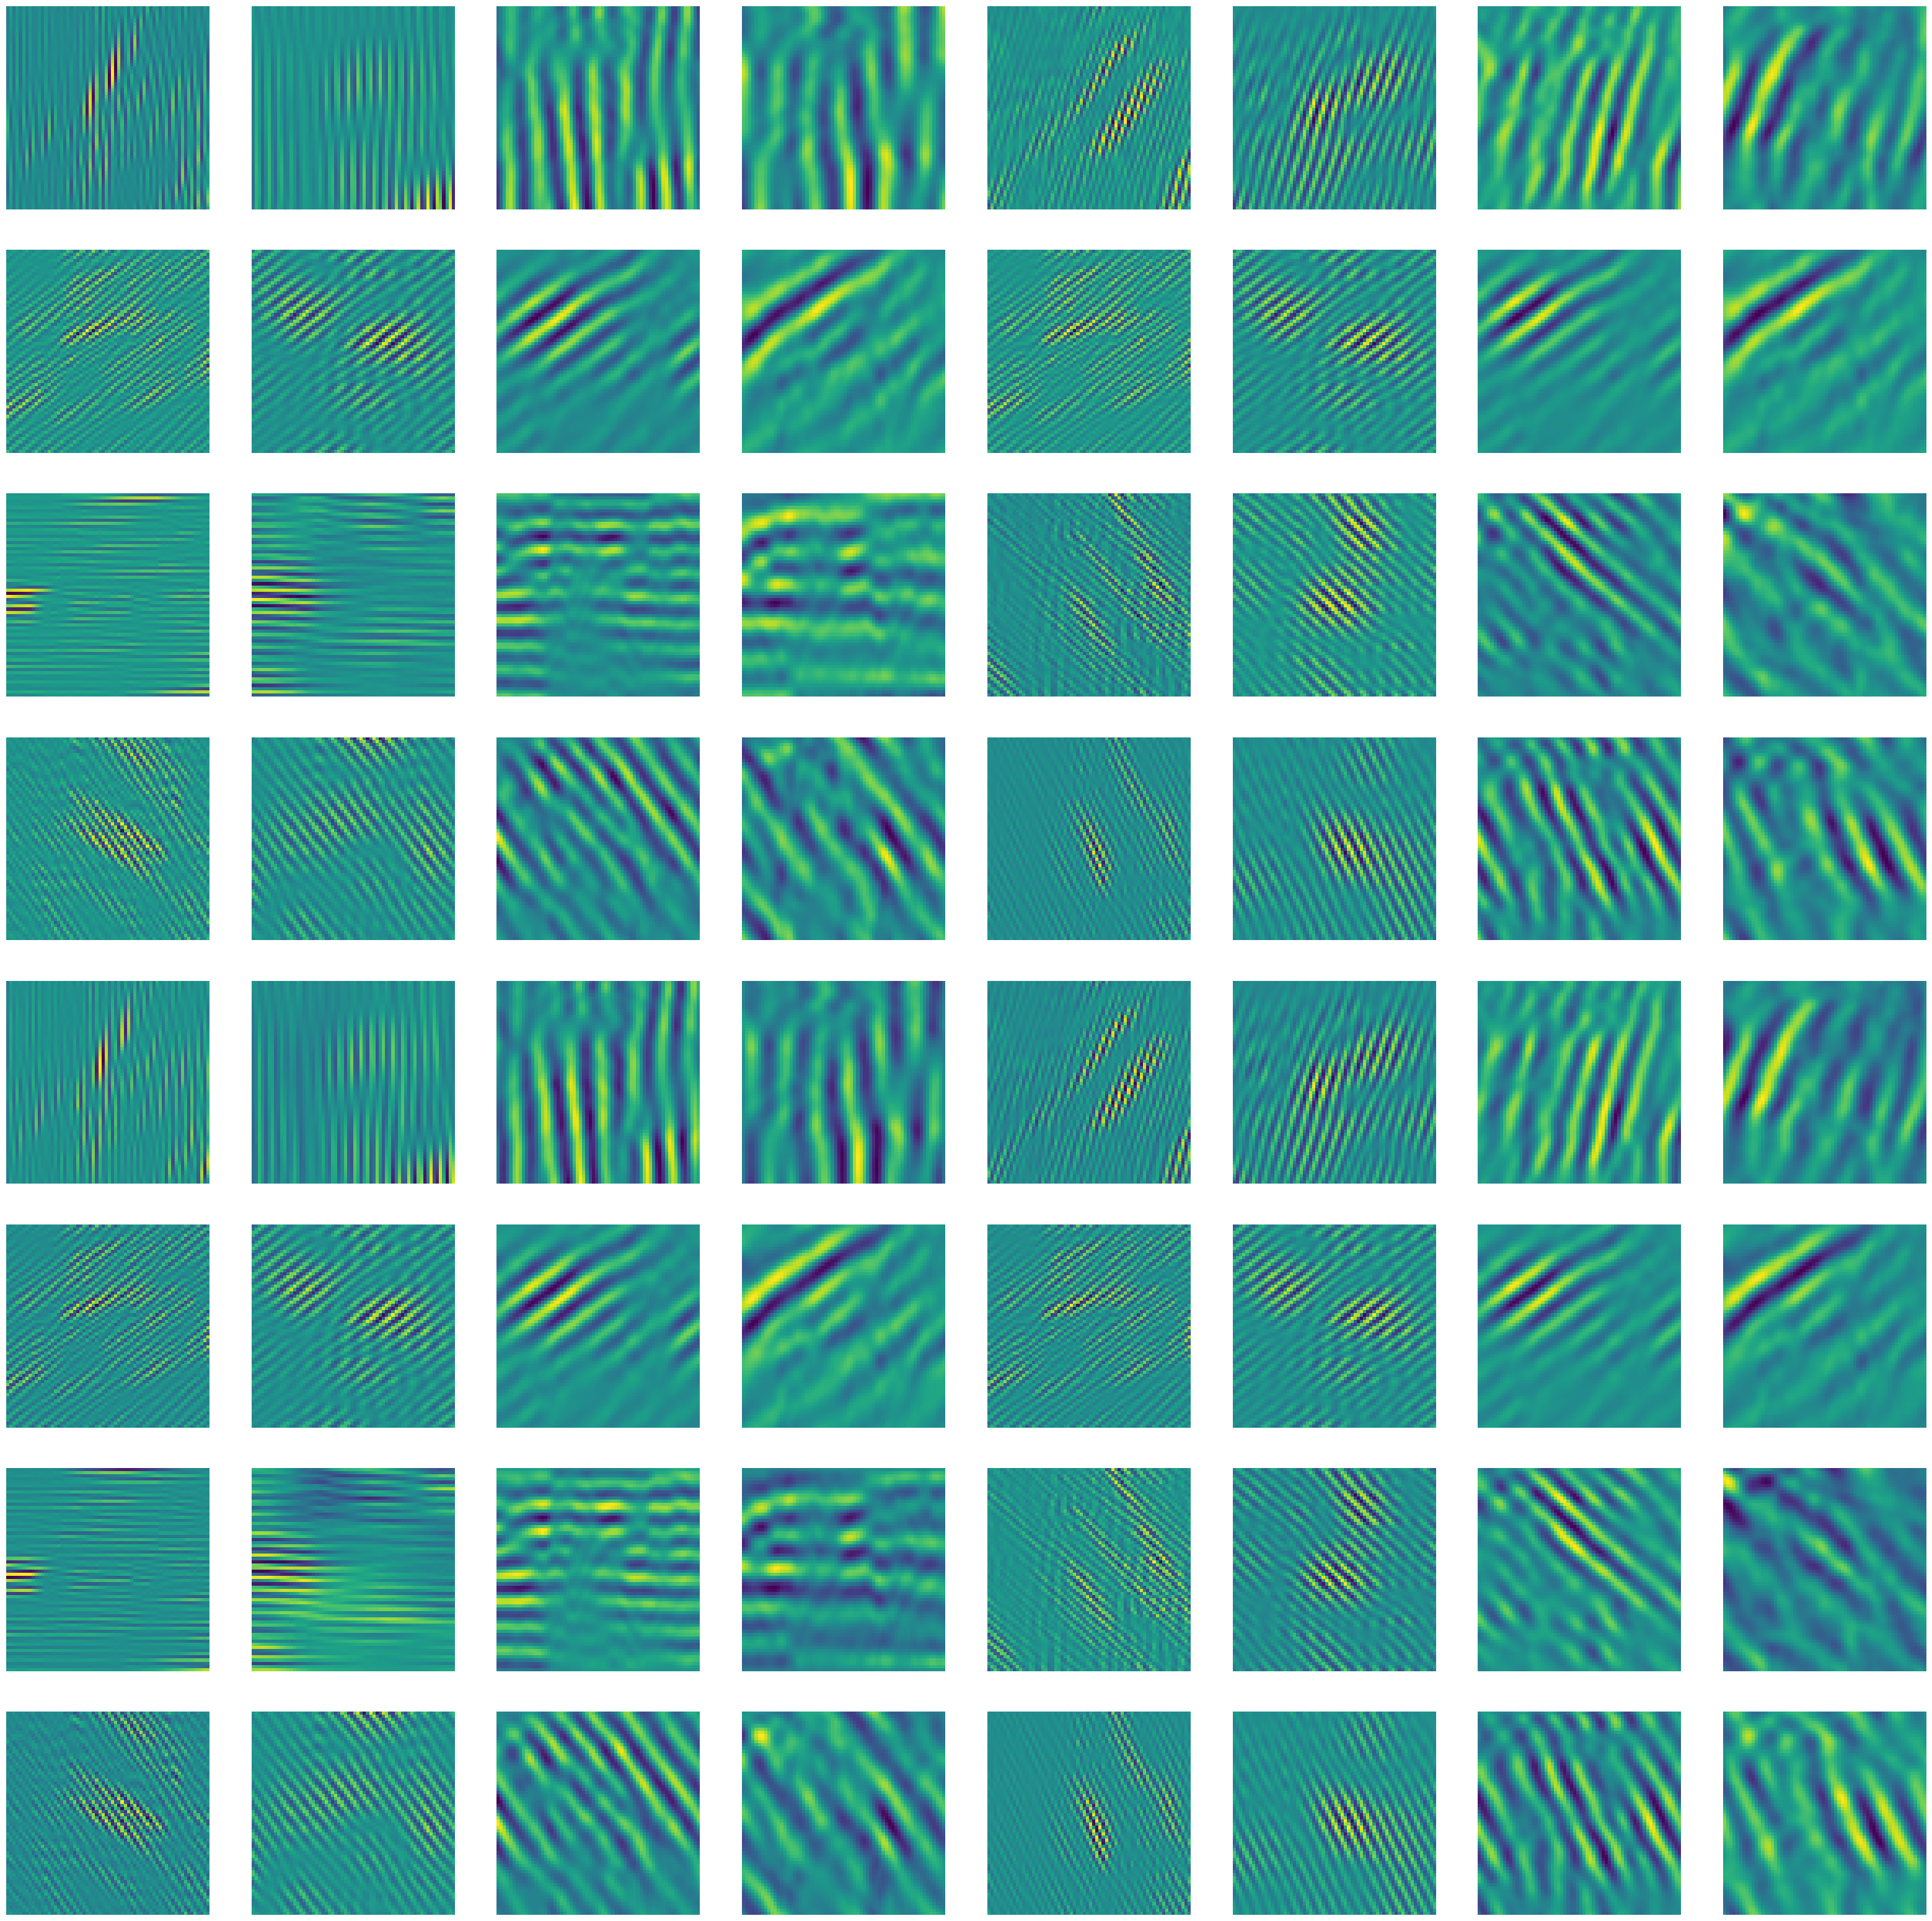

In [ ]:
fig, axes = plt.subplots(8,8, figsize=(40,40))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(outputs[0,:,:,i])
    ax.axis("off")
plt.show()